# Práctico 2: Leaky Integrate and Fire

Este modelo sencillo de neurona captura varios comportamientos de las neuronas reales. Veremos su respuesta ante deferentes estímulos, en particular su patron de respuesta frente al ruido en la entrada.

\begin{equation} I(t)={u(t)-v{\rm rest}\over R}+C\,{{\text{d}}v\over{\text{d}}t}\,.\end{equation}
\begin{equation} \tau_{m}\,{{\text{d}}v\over{\text{d}}t}=-[v(t)-v_{\rm rest}]+R\,I(t)\,.\end{equation}

## Configuración

Ejecutá las siguientes celdas para configurar el entorno del notebook

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy as sp
import ipywidgets as widgets
from scipy.integrate import odeint
from scipy import stats
from matplotlib import gridspec

### Funciones utilitarias

In [25]:
def I_inj(t, amp1, dur1, amp2=0, dur2=0, sep=50):
  """Crea una función de corriente inyectada con dos pulsos cuadrados.

  Args:
    t (ndarray): vector 1D de tiempos (ms), estrictamente creciente.
    amp1 (float): amplitud del primer pulso, en uA/cm^2.
    dur1 (float): duración del primer pulso, en ms.
    amp2 (float): amplitud del segundo pulso, en uA/cm^2.
    dur2 (float): duración del segundo pulso, en ms.
    sep (float): separación mínima entre los dos pulsos, en ms.

  Returns:
    function: una función I(t) que devuelve la corriente inyectada I(t).
  """
  tmax = np.max(t)
  inicios = np.linspace(0, tmax, 8)
  inicio1 = inicios[1]
  inicio2 = inicio1 + dur1 + sep
  
  def I(t):
    return (amp1 * (t > inicio1) - amp1 * (t > inicio1 + dur1) +
            amp2 * (t > inicio2) - amp2 * (t > inicio2 + dur2))

  return I

def I_train(t, n, amp, dur, interval, start=50):
  """Crea una función de corriente inyectada con n pulsos cuadrados.

  Args:
    t (ndarray): vector 1D de tiempos (ms), estrictamente creciente.
    n (int): número de pulsos.
    amp (float): amplitud de cada pulso, en uA/cm^2.
    dur (float): duración de cada pulso, en ms.
    interval (float): intervalo entre el inicio de un pulso y el siguiente, en ms.
    start (float): tiempo inicial del primer pulso, en ms.

  Returns:
    function: una función I(t) que devuelve la corriente inyectada I(t).
  """
  # Tiempos de inicio de cada pulso
  inicios = start + np.arange(n) * interval

  def I(t):
    corriente = np.zeros_like(t, dtype=float)
    for inicio in inicios:
      corriente += amp * ((t > inicio) & (t <= inicio + dur))
    return corriente

  return I

def contar_potenciales_de_accion(mascara):
  """Cuenta los potenciales de acción a partir de una máscara booleana.

  Args:
    mascara (ndarray): máscara booleana con True en cada cruce ascendente.

  Returns:
    int: número de potenciales de acción detectados.
  """
  return np.sum(mascara)

def medir_isis(mascara):
  ix, = np.nonzero(mascara)
  return np.array([(ix[i+1]-ix[i])/10 for i in range(len(ix)-1)])

### Funciones de graficado

In [3]:
def plotLIF(voltajes, espigas, t, corriente):
    plt.figure(figsize=(10,5))
    gs = gridspec.GridSpec(3, 1,height_ratios=[1,4,1])
    
    plt.subplot(gs[0])
    plt.ylim(0.2,0.3)
    plt.ylabel(u'Espigas')
    plt.plot(t,0.25*espigas,'*')
    plt.subplot(gs[1])
    plt.ylabel(u'Voltaje (sub-umbral)')
    plt.xlabel(u'tiempo')
    plt.ylim(-80,theta+20)
    plt.plot(t,[theta]*len(t),'k-')
    plt.plot(t,voltajes)
    plt.subplot(gs[2])
    plt.ylim(-55,55)
    plt.ylabel(u'Corriente inyectada')
    plt.plot(t,corriente,'r-')

## Definición del modelo

In [4]:
#Constantes del modelo
E_L=-65.0 #potencial de reposo
tau=5  #constante de tiempo
theta=-55.0  #umbral de disparo
dt=0.1    #paso de la integración
dt_1=int(1/dt)  # inverso del paso de integración, útil para algunas cuentas
tiempoMax=300
iteraciones=int(tiempoMax/dt)

### Definimos las ecuaciones del modelo

In [43]:
def correrLIF(t, pulsos):
  voltajes = np.zeros(len(t))
  espigas = np.zeros(len(t))
  corriente = np.zeros(len(t))
  V = E_L #comenzamos en el resting state
  for i,t_step in enumerate(t):
    s = V > theta  #cruzamos el umbral?
    V = s*E_L + (1-s)*(V-dt/tau*((V-E_L)-pulsos[i]))
    voltajes[i]=V
    espigas[i]=s
    corriente[i]=pulsos[i]
  return voltajes, espigas, t, corriente 

## Simulación del modelo

#### Corriente externa constante

In [6]:
@widgets.interact(amp1=(-50, 50, 0.1), dur1=(0, 100, 1), amp2=(-50, 50, 0.1), dur2=(0, 100, 1), sep=(0, 200, 1))
def plot_I_inj(amp1=15, dur1=2, amp2=15, dur2=0, sep=50):
  t = np.arange(0, 300, 0.1)
  I = I_inj(t, amp1, dur1, amp2, dur2, sep)
  voltajes, espigas, t, corriente=correrLIF(I(t))
  plotLIF(voltajes, espigas, t, corriente)

interactive(children=(FloatSlider(value=15.0, description='amp1', max=50.0, min=-50.0), IntSlider(value=2, des…

#### Suma de pulsos de corriente

In [7]:
@widgets.interact(n=(0, 10), dur=(0, 10), amp=(-15, 15, 0.1), dur2=(0, 100, 1), sep=(0, 100, 1))
def plot_I_train(n=5, dur=2, amp=15, sep=3):
  t = np.arange(0, 300, 0.1)
  I = I_train(t, n, amp, dur, sep)
  voltajes, espigas, t, corriente=correrLIF(I(t))
  plotLIF(voltajes, espigas, t, corriente)

interactive(children=(IntSlider(value=5, description='n', max=10), IntSlider(value=2, description='dur', max=1…

## Modelando el ruido en la entrada

### Ruido gaussiano en la corriente de entrada
¿Cómo es el patrón de descarga si la corriente de entrada tiene ruido gaussiano?
El parametro <b>media</b> controla la amplitud promedio del ruido, y el <b>desvio</b> controla la variabilidad. Al aumentar la varibilidad, ¿qué pasa con la respuesta de la neurona?

Experimentar:
<ol>
<li> Aumentando la variabilidad.</li>
<li> Aumentando la amplitud (dejando la variabilidad fija, y no muy alta).</li>
<li> Aumentando la amplitud de la entrada de base (RI_ext).</li>

</ol>


In [8]:
def I_inj_ruido(t, amp=8, sigma=4):
  tmax = np.max(t)

  base = amp * (t > 0)
  vals = base + np.random.normal(0.0, sigma, size=t.shape)

  def I(tq):
    return np.interp(tq, t, vals)

  return I

@widgets.interact(amp=(-15, 15, 0.1), sigma=(0, 10, 0.1))
def plot_I_inj_ruido(amp=8, sigma=4):
  t = np.arange(0, 300, 0.1)
  I = I_inj_ruido(t, amp, sigma)
  
  plt.subplot(2,1,1)
  plt.hist(I(t))
  plt.xlabel(u'Amplitud de la señal de entrada')
  plt.title(u'Histograma de la señal de entrada')
  plt.subplot(2,1,2)
  plt.plot(t, I(t))
  plt.show()

interactive(children=(FloatSlider(value=8.0, description='amp', max=15.0, min=-15.0), FloatSlider(value=4.0, d…

Corremos y ploteamos el resultado

In [12]:
@widgets.interact(amp=(-15, 15, 0.1), sigma=(0, 10, 0.1))
def plot_I_inj_ruido(amp=8, sigma=4):
  t = np.arange(0, 300, 0.1)
  I = I_inj_ruido(t, amp, sigma)
  
  voltajes, espigas, t, corriente=correrLIF(I(t))
  plotLIF(voltajes, espigas, t, corriente)

interactive(children=(FloatSlider(value=8.0, description='amp', max=15.0, min=-15.0), FloatSlider(value=4.0, d…

### Relación entrada vs. frecuencia de disparo (con ruido)

En ausencia de ruido, la relación entre amplitud de la entrada y frecuencia de disparo es similar a la que vimos en el práctico pasado. ¿Se modifica esa relación ante el ruido?

Probar:
<ol>
<li>La relación sin ruido (amplitud 0, variabilidad 0).</li>
<li>Aumentar la variabilidad (correr varias veces).</li>
<li>Aumentar la amplitud promedio del ruido (corre varias veces)</li>
</ol>

In [21]:
help(contar_potenciales_de_accion)

Help on function contar_potenciales_de_accion in module __main__:

contar_potenciales_de_accion(mascara)
    Cuenta los potenciales de acción a partir de una máscara booleana.
    
    Args:
      mascara (ndarray): máscara booleana con True en cada cruce ascendente.
    
    Returns:
      int: número de potenciales de acción detectados.



In [50]:
t = np.arange(0.0, 200.0, 0.1)

@widgets.interact(sigma=(0, 30, 0.1))
def simulate(sigma = 4.0):
  corrientes = np.arange(0, 12, 0.1)
  frecuencias = np.zeros_like(corrientes)
  for i, amp in enumerate(corrientes):
    I = I_inj_ruido(t, amp, sigma)
    voltajes, espigas, _, corriente = correrLIF(t, I(t))
    frecuencias[i] = contar_potenciales_de_accion(espigas)
    
  plt.scatter(corrientes, frecuencias)
  plt.show()

interactive(children=(FloatSlider(value=4.0, description='sigma', max=30.0), Output()), _dom_classes=('widget-…

In [ ]:
media=0 # amplitud del ruido
desvio=0 #variabilidad del ruido

def calcularFrec(espigas):
    #en qué momento cruza el valor de 10 mV
    indEspigas,=np.nonzero(espigas)
    #en qué posición de tiempo pasa eso?
    #frecuencia promedio de disparo, como inverso de el ISI
    if len(indEspigas)>1:
        return np.mean([10000.0/(indEspigas[i+1]-indEspigas[i]) for i in range(len(indEspigas)-1)])
    else:
        return 0

    
# Vamos a simular va
#rango de amplitudes de corriente
tiempoMax=2000
rangoCorrientes=np.arange(0,12,.1)
frecuencia=[]
for amp in rangoCorrientes:
    corrR=setRuido(amp,media,desvio)

    voltajes, espigas, t, corriente=correrLIF2(tiempoMax)
    frecuencia.append(sum(espigas))
    
plt.figure(figsize=(8, 6))
plt.plot(rangoCorrientes,frecuencia)
plt.xlabel(u'Amplitud de "corriente" inyectada (RI_ext)')
plt.ylabel(u'Frecuencia promedio de disparo (Hz)')
plt.title(u'Relación entrada - salida')
plt.show()



### Estadística de disparo en la entrada 
Ya vimos la frecuencia promedio en función de la entrada ruidosa. Pero se observa ruido en la salida. La frecuencia parece no ser constante para cada valor de entrada. ¿Qué pasa con los intervalos entre espigas? ¿Cómo se ve la distribución de intervalos entre espigas, y cómo la afecta la amplitud y la variabilidad del ruido en la entrada?
¿Es una distribución realista? (ver figuras 3.5, 3.7 y 3.8 del Trappenberg).

<ul>
<li>Jugar con los parámetros de la entrada, RI_ext y amplitud y variabilidad del ruido</li>
<li>¿Qué pasa si RI_ext es alto y la amplitud es 0 y la variabilidad baja?</li>
<li>Observar la forma del histograma</li>
<li>Mirar el coeficiente de variación (último número que sale debajo de la gráfica)</li>
</ul>


In [53]:
@widgets.interact(amp=(0,12,0.1), sigma=(0, 30, 0.1))
def simulate(amp=9, sigma=4.0):
  t = np.arange(0.0, 20_000.0, 0.1)
  I = I_inj_ruido(t, amp, sigma)
  voltajes, espigas, t, corriente = correrLIF(t, I(t))
  
  def medir_isis(mascara):
    ix, = np.nonzero(mascara)
    return np.array([(ix[i+1]-ix[i])/10 for i in range(len(ix)-1)])
    
  ISIs=medir_isis(espigas)
  
  plt.figure(figsize=(8, 6))
  plt.hist(ISIs,20)
  plt.xlabel('Intervalo entre espigas (ms)')
  plt.ylabel('Frecuencia')
  plt.title('Histograma del intervalo entre espigas')
  plt.show()

interactive(children=(FloatSlider(value=9.0, description='amp', max=12.0), FloatSlider(value=4.0, description=…

## Una población de neuronas LIF

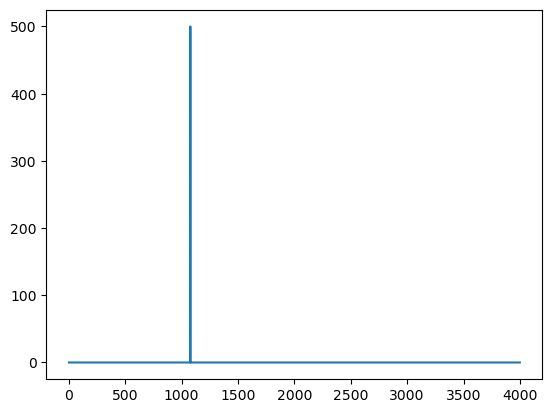

In [38]:
tiempoMax=400 #200 milisegundos. 
numNeuronas=500 # si se vuelve muy lento el cálculo, se puede bajar a 100 o 500

media=6 #amplitud del ruido
desvio=4#variabilidad del ruido
RI_ext=8 # corriente de base


RI_ext2=20 # salto en la amplitud de la corriente base

neuronas=np.zeros([numNeuronas,int(tiempoMax/dt)])
voltajes=np.zeros([numNeuronas,int(tiempoMax/dt)])


t = np.arange(0.0, 400, 0.1)
for i in range(len(neuronas)):
    v, espigas, t, corriente = correrLIF(I(t))
    voltajes[i]=v
    neuronas[i]=espigas
    ISIs=medir_isis(espigas)


espigasPobl=sum(neuronas)
frecPobl=[sum(espigasPobl[i*dt_1:(i+1)*dt_1]) for i in range(int(len( espigasPobl )/dt_1))]
#frecPobl=[sum(espigasPobl[i*dt_1:(i+1)*dt_1])]
plt.plot(np.sum(neuronas,axis=0))

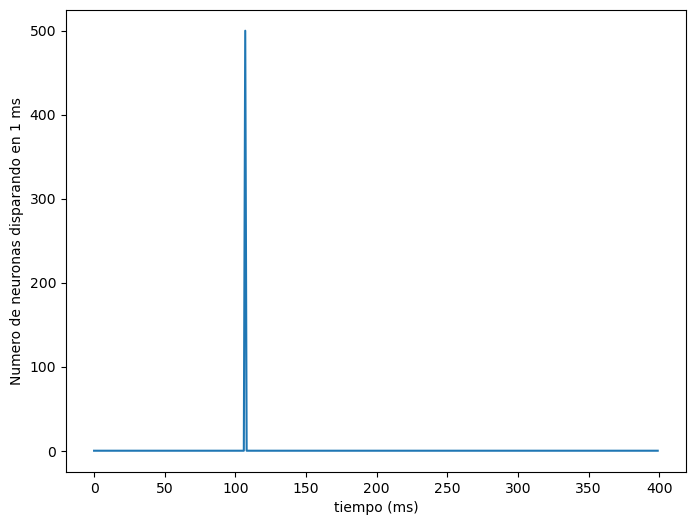

In [39]:
#len(espigasPobl)
plt.figure(figsize=(8, 6))
plt.plot(frecPobl)
plt.ylabel(u'Numero de neuronas disparando en 1 ms')
plt.xlabel(u'tiempo (ms)')
plt.show()

# Modelo de respusta a espiga (LIF)
Aquí veremos la respuesta de una neurona a muchas espigas presinápticas aleatorias. Vamos a seguir las ecuaciones del Trappenberg, capítulo 3.1.4


In [ ]:
#Constantes del modelo
E_L=-65.0 #potencial de reposo
tau=10.0  #constante de tiempo
theta=-55.0  #umbral de disparo

In [ ]:
plt.plot(ISIs/dt_1)

In [ ]:
tiempoMax/2

In [ ]:
a,=np.nonzero(espigas)
len(a)